In [68]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, shape
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt, label, binary_dilation
import random
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
from shapely.ops import unary_union
from skimage.measure import find_contours
from scipy.special import expit  # Logistic sigmoid function
import logging
from typing import Dict, Tuple, List, Optional


## **Load Data and Voronoi Districts**

In [69]:

# =======================
# Loading data
# =======================

precinct_shapefile = 'fl_2016/fl_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)

# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
raster_bands = []
for col in selected_columns:
    # Create shapes for rasterization with scaled values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band, red_band = raster_bands

# total votes/population per pixel
population = blue_band + red_band 

# =======================
# Florida mask
# this part ignores pixels that are not within Florida
# =======================

# get the boundary of Florida state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the Florida boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Florida mask to the population array
# Pixels outside Florida will have population = 0
population_masked = population * florida_mask


In [70]:

def generate_voronoi_districts(population_masked, num_districts=27, random_seed=None):
    """
    Generates Voronoi-based districts within Florida based on a population raster.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Florida.
        num_districts (int): Number of districts to generate. Default is 27.
        tolerance (float): Population tolerance (unused in Voronoi, but kept for reference). Default is 50000.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Florida are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # specify seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts
    # print("Total population within Florida:", total_pop)
    # print("Target population per district:", target_pop)

    # =======================
    # Voronoi Tesselation
    # =======================

    # get pixels within Florida
    valid_pixels = np.argwhere(population_masked > 0)
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # randomly sample 27 pixels (one for each district)
    seed_indices = random.sample(range(valid_pixels.shape[0]), num_districts)
    seed_coords = valid_pixels[seed_indices]

    # create an empty district map
    # initialize with -1 for ocean pixels (outside Florida)
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # compute Voronoi Tessellation
    # Create a boolean array where seed pixels are True
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    # find the nearest pixel to each sampled pixel
    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)

    # assign each pixel to the nearest seed's district ID
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    # update the district map for all valid pixels
    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population and Vote Percentages
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []
    total_blue = []
    total_red = []
    percentage_blue = []
    percentage_red = []

    # create data frame with population and votes per district
    # ---------------------------------------

    for d_id in district_ids:
        # Create a mask for the current district
        mask = (district_map == d_id)
        
        # Calculate total population for the district
        pop = population_masked[mask].sum()
        total_population.append(pop)
        
        # Calculate total blue and red votes for the district
        blue = blue_band[mask].sum()
        red = red_band[mask].sum()
        total_blue.append(blue)
        total_red.append(red)
        
        # Calculate percentage of blue and red votes
        if pop > 0:
            percentage_blue.append((blue / pop) * 100.0)
            percentage_red.append((red / pop) * 100.0)
        else:
            percentage_blue.append(0)
            percentage_red.append(0)
    
    # ---------------------------------------

    data = {
        'District': district_ids,
        'Total Population': total_population,
        'Blue Votes': total_blue,
        'Red Votes': total_red,
        'Percentage Blue': percentage_blue,
        'Percentage Red': percentage_red
    }

    df = pd.DataFrame(data)

    # =======================
    # Plots:
    # =======================

    #  Voronoi Districts
    # ------------------------
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
    custom_cmap = ListedColormap(colors)

    # Adjust district_map to Shift -1 to the Last Index (for black color)
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

    # Combine all plots in 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1
    im = axes[0].imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Voronoi Districts", fontsize=14)

    # Population and Votes per District
    # ------------------------
    # Plot 2: Total Population per District
    axes[1].bar(df['District'], df['Total Population'], color='lightgreen')
    axes[1].set_xlabel('District ID', fontsize=12)
    axes[1].set_ylabel('Total Population', fontsize=12)
    axes[1].set_title('Total Population per District', fontsize=14)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Percentage of Blue vs Red Votes per District
    width = 0.6  # Width of the bars
    axes[2].bar(df['District'], df['Percentage Blue'], width, label='Blue', color='skyblue')
    axes[2].bar(df['District'], df['Percentage Red'], width, bottom=df['Percentage Blue'], label='Red', color='pink')
    axes[2].set_xlabel('District ID', fontsize=12)
    axes[2].set_ylabel('Percentage of Votes (%)', fontsize=12)
    axes[2].set_title('Percentage of Blue vs Red Votes', fontsize=14)
    axes[2].legend(fontsize=10)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # =======================
    
    return district_map, seed_coords, target_pop


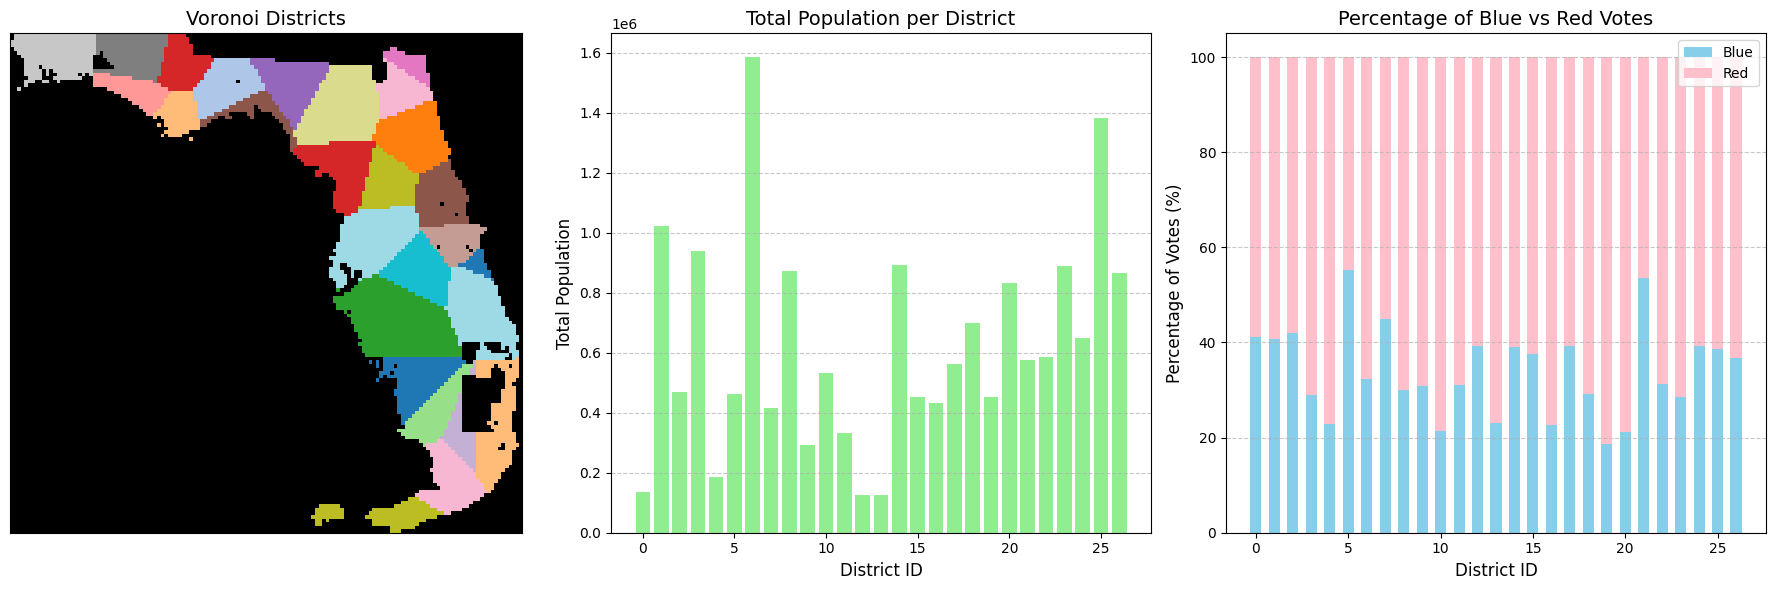

In [122]:
district_map, seed_coords, target_pop = generate_voronoi_districts(population_masked, 27)

## **Remove Islands**

In [72]:
def enforce_largest_connected_component(district_map):
    """
    Enforce contiguity by retaining only the largest connected component
    across the entire district map, removing all other smaller components.

    Parameters:
        district_map (np.ndarray): 2D array with district IDs (>= 0) and -1 for outside areas.

    Returns:
        np.ndarray: Updated district map with only the largest connected component retained.
    """
    # Mask to ignore ocean/outside (-1)
    valid_mask = district_map >= 0

    # Label connected components across the entire map
    labeled, num_components = label(valid_mask)

    if num_components <= 1:
        return district_map  # Already one connected component

    # Find the largest connected component
    component_sizes = [(comp_label, np.sum(labeled == comp_label)) for comp_label in range(1, num_components + 1)]
    largest_label = max(component_sizes, key=lambda x: x[1])[0]  # Find label with the largest size

    # Create a mask for the largest connected component
    largest_component_mask = (labeled == largest_label)

    # Set all other regions to -1 (outside)
    district_map[~largest_component_mask] = -1

    return district_map

In [123]:
district_map = enforce_largest_connected_component(district_map)

## **Optimization**

### Logistic Regression

In [74]:
def logistic_regression_probability(percent_red, w0=-5, w1=0.1):
    """
    Compute the probability of a Republican win using a logistic regression model.

    Parameters:
        percent_red (float): Percentage of Republican voters in the district.
        w0 (float): Intercept term.
        w1 (float): Coefficient for percent_red.

    Returns:
        float: Probability of Republican win.
    """
    return 1 / (1 + np.exp(-(w0 + w1 * percent_red)))

### Plotting Function

In [121]:
def plot_district_map_with_population_interactive(
    district_map,
    population_masked,
    red_votes_dict,    # Existing parameter
    pop_dict,          # New parameter
    num_districts,     # New required parameter
    iteration=None,
    population_losses=None,
    compactness_losses=None,
    favorability_losses=None,  # Existing parameter
    total_losses=None,
    temperatures=None,
):
    """
    Dynamically visualize the district map, population chart, favorability, and loss curves.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population values per pixel.
        red_votes_dict (dict): Republican votes per district.
        pop_dict (dict): Population per district.
        num_districts (int): Total number of districts.
        iteration (int, optional): Current iteration number.
        population_losses (list, optional): List of population losses over iterations.
        compactness_losses (list, optional): List of compactness losses over iterations.
        favorability_losses (list, optional): List of favorability losses over iterations.
        total_losses (list, optional): List of total losses over iterations.
        temperatures (list, optional): List of temperatures over iterations.
    """
    from IPython.display import display, clear_output

    # Clear the current output in Jupyter or console
    clear_output(wait=True)

    # Calculate population per district
    district_ids = range(num_districts)
    total_population = []
    for d_id in district_ids:
        mask = (district_map == d_id)
        pop = population_masked[mask].sum()
        total_population.append(pop)

    # Calculate favorability per district
    total_favorability = []
    for d_id in district_ids:
        if pop_dict[d_id] > 0:
            percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0
            prob_win = logistic_regression_probability(percent_red, w0=-5, w1=0.1)  # Ensure w0 and w1 are accessible
            total_favorability.append(prob_win)
        else:
            total_favorability.append(0)

    # Create colormap for districts
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    custom_colors = list(district_colors) + [(0, 0, 0, 1)]  # Black for -1
    custom_cmap = ListedColormap(custom_colors)

    # Shift -1 to the last index
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts

    # Initialize figure with 4 columns for map, population, favorability, and losses
    fig, axes = plt.subplots(1, 4, figsize=(32, 8))

    # Plot district map
    im = axes[0].imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Voronoi Districts" + (f" - Iteration {iteration}" if iteration is not None else ""), fontsize=14)

    # Plot Total Population per District
    axes[1].bar(district_ids, total_population, color='lightgreen')
    axes[1].set_xlabel('District ID', fontsize=12)
    axes[1].set_ylabel('Total Population', fontsize=12)
    axes[1].set_title('Total Population per District', fontsize=14)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Favorability per District
    axes[2].bar(district_ids, total_favorability, color='salmon')
    axes[2].set_xlabel('District ID', fontsize=12)
    axes[2].set_ylabel('Probability of Rep Win', fontsize=12)
    axes[2].set_title('Favorability per District', fontsize=14)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot loss and temperature curves
    if (population_losses is not None and compactness_losses is not None and 
        favorability_losses is not None and total_losses is not None and 
        temperatures is not None):
        axes[3].plot(population_losses, label="Population Loss", color="blue")
        axes[3].plot(compactness_losses, label="Compactness Loss", color="green")
        axes[3].plot(favorability_losses, label="Favorability Loss", color="red")
        axes[3].plot(total_losses, label="Total Loss", color="purple")
        # axes[3].plot(temperatures, label="Temperature", color="orange")
        axes[3].set_title("Loss Over Iterations", fontsize=14)
        axes[3].set_xlabel("Iteration", fontsize=12)
        axes[3].set_ylabel("Loss / Temperature", fontsize=12)
        axes[3].legend()
        axes[3].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


### District Votes and Population

In [76]:
def calculate_district_votes(district_map, red_band):
    """
    Calculate the total Republican votes for each district.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        dict: Dictionary mapping district IDs to total Republican votes.
    """
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    red_votes_dict = {}
    for d_id in unique_districts:
        red_votes_dict[d_id] = red_band[district_map == d_id].sum()
    return red_votes_dict

def calculate_district_data(district_map, population_masked, red_band):
    """
    Calculate population and Republican votes for each district.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        population_masked (np.ndarray): 2D array of population per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        tuple: (pop_dict, red_votes_dict)
    """
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    pop_dict = {}
    red_votes_dict = {}
    for d_id in unique_districts:
        mask = (district_map == d_id)
        pop_dict[d_id] = population_masked[mask].sum()
        red_votes_dict[d_id] = red_band[mask].sum()
    return pop_dict, red_votes_dict

### Compactness

In [77]:
def calculate_compactness(district_map, district_id):
    """
    Calculate the compactness (perimeter-to-area ratio) of a district.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        district_id (int): ID of the district to evaluate.

    Returns:
        float: Compactness score (lower is better).
    """
    # Create a mask for the district
    district_mask = (district_map == district_id)
    if not district_mask.any():  # Skip if the district does not exist
        return float('inf')

    # Find the contours of the district
    contours = find_contours(district_mask.astype(int), 0.5)
    if not contours:
        return float('inf')  # No valid contours

    # Create polygons from contours
    polygons = []
    for contour in contours:
        if len(contour) > 2:  # Ensure at least 3 points
            poly = Polygon(contour)
            if poly.is_valid and poly.area > 0:  # Filter invalid or zero-area polygons
                polygons.append(poly)

    if not polygons:
        return float('inf')  # No valid polygons

    # Union all regions to form the full district geometry
    try:
        district_polygon = unary_union(polygons)
    except Exception as e:
        print(f"Error during union operation: {e}")
        return float('inf')

    # Calculate compactness = Perimeter / sqrt(Area)
    perimeter = district_polygon.length
    area = district_polygon.area
    if area == 0:
        return float('inf')  # Avoid division by zero

    return perimeter / (area ** 0.5)

### Loss Functions

In [78]:
def calculate_loss(district_map, pop_dict, red_votes_dict, target_pop, alpha, beta, gamma, w0=-5, w1=0.1):
    """
    Calculate the combined loss including population imbalance, compactness, and party favorability.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        pop_dict (dict): Population of each district.
        red_votes_dict (dict): Total Republican votes per district.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        gamma (float): Weight for favorability.
        w0 (float): Intercept for logistic regression.
        w1 (float): Coefficient for percent_red in logistic regression.

    Returns:
        tuple: (weighted_pop_imbalance, weighted_compactness, weighted_favorability, total_loss)
    """
    # Population imbalance
    pop_imbalance = sum((pop - target_pop) ** 2 for pop in pop_dict.values())
    weighted_pop_imbalance = beta * pop_imbalance

    # Compactness
    compactness_score = sum(
        calculate_compactness(district_map, d_id) for d_id in np.unique(district_map) if d_id >= 0
    )
    weighted_compactness = alpha * compactness_score

    # Favorability
    favorability_sum = 0
    for d_id in pop_dict:
        percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0  # Percentage of Republican voters
        prob_win = logistic_regression_probability(percent_red, w0, w1)
        favorability_sum += prob_win

    weighted_favorability = gamma * favorability_sum

    # Combined loss
    total_loss = weighted_pop_imbalance + weighted_compactness + weighted_favorability

    return weighted_pop_imbalance, weighted_compactness, weighted_favorability, total_loss

### Get Border Pixels

In [79]:
def get_border_pixels(district_map):
    """
    Identify border pixels of districts. A border pixel is one that is part of a district
    but is adjacent to a pixel of a different district or -1.
    """
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    border_pixels = []

    for r in range(height):
        for c in range(width):
            d_id = district_map[r, c]
            if d_id < 0:  # Skip outside regions
                continue
            # Check neighbors
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width:
                    if district_map[nr, nc] != d_id:  # Different district or -1
                        border_pixels.append((r, c))
                        break
    return border_pixels

### Flipping Algorithm

In [80]:
def flip_pixel_with_votes(district_map, pop_dict, red_votes_dict, pixel, new_d, population_masked, red_band):
    """
    Perform the flip of a pixel to a new district and update the population and vote dictionaries.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        pop_dict (dict): Population per district.
        red_votes_dict (dict): Republican votes per district.
        pixel (tuple): (row, column) of the pixel to flip.
        new_d (int): New district ID to assign.
        population_masked (np.ndarray): 2D array of population per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        tuple: Updated (district_map, pop_dict, red_votes_dict)
    """
    r, c = pixel
    old_d = district_map[r, c]
    pixel_pop = population_masked[r, c]
    pixel_red = red_band[r, c]

    # Update district_map
    district_map[r, c] = new_d

    # Update population dictionary
    pop_dict[old_d] -= pixel_pop
    pop_dict[new_d] += pixel_pop

    # Update Republican votes dictionary
    red_votes_dict[old_d] -= pixel_red
    red_votes_dict[new_d] += pixel_red

    return district_map, pop_dict, red_votes_dict

In [81]:
def is_contiguous_after_flip(district_map, current_d, r, c):
    """
    Check if the district `current_d` remains contiguous after removing the pixel `(r, c)`.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        current_d (int): District ID of the pixel being removed.
        r (int): Row index of the pixel to remove.
        c (int): Column index of the pixel to remove.

    Returns:
        bool: True if the district remains contiguous, False otherwise.
    """
    district_mask = (district_map == current_d)
    labeled, num_components = label(district_mask)

    # Create a temporary mask for the current district
    district_mask = (district_map == current_d)

    # Remove the pixel (r, c) from the district mask
    district_mask[r, c] = False

    # Check connected components in the modified district mask
    labeled2, num_components2 = label(district_mask)

    # If there is more than one component, the district is disconnected
    return num_components2 == num_components

In [85]:
def evaluate_flip_and_loss_optimized(
    district_map,
    population_masked,
    pop_dict,
    red_votes_dict,
    pixel,
    target_pop,
    alpha,
    beta,
    gamma,
    w0,
    w1,
    current_loss
):
    """
    Evaluate flipping a border pixel and calculate the resulting loss efficiently.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population values per pixel.
        pop_dict (dict): Current population per district.
        red_votes_dict (dict): Current Republican votes per district.
        pixel (tuple): (row, column) of the pixel to potentially flip.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        gamma (float): Weight for favorability.
        w0 (float): Intercept for logistic regression.
        w1 (float): Coefficient for percent_red in logistic regression.
        current_loss (tuple): Current loss components.

    Returns:
        tuple: (best_new_district, best_delta_loss, best_new_loss)
    """
    r, c = pixel
    current_d = district_map[r, c]

    # Identify candidate new districts from neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    candidate_districts = set()
    for dr, dc in neighbors:
        nr, nc = r + dr, c + dc
        if 0 <= nr < height and 0 <= nc < width:
            if district_map[nr, nc] >= 0 and district_map[nr, nc] != current_d:
                candidate_districts.add(district_map[nr, nc])
    if not candidate_districts:
        return None, None, current_loss  # No valid flip

    # Extract current losses
    current_pop_loss, current_compact_loss, current_favor_loss, current_total_loss = current_loss

    best_new_d = None
    best_delta_loss = float("inf")  # Ensure this is a scalar
    best_new_loss = current_loss

    pixel_pop = population_masked[r, c]
    # Approximate pixel_red as proportional to pixel_pop
    pixel_red = red_votes_dict[current_d] * (pixel_pop / pop_dict[current_d]) if pop_dict[current_d] > 0 else 0

    for new_d in candidate_districts:
        # Check contiguity before simulating the flip
        if not is_contiguous_after_flip(district_map, current_d, r, c):
            continue  # Skip this flip as it would disconnect the current district

        # Simulate the flip
        pop_dict_new = pop_dict.copy()
        pop_dict_new[current_d] -= pixel_pop
        pop_dict_new[new_d] += pixel_pop

        red_votes_new = red_votes_dict.copy()
        # Assuming pixel_red is proportionally moved; adjust as per actual data
        red_votes_new[current_d] -= pixel_red
        red_votes_new[new_d] += pixel_red

        # Compute new loss components
        new_pop_loss = sum((pop_dict_new[d] - target_pop) ** 2 for d in pop_dict_new)
        weighted_pop_loss = beta * new_pop_loss

        # Compute new compactness
        new_compactness = sum(
            calculate_compactness(district_map, d_id) for d_id in np.unique(district_map) if d_id >= 0
        )
        weighted_compactness = alpha * new_compactness

        # Compute new favorability
        favorability_sum = 0
        for d_id in pop_dict_new:
            if pop_dict_new[d_id] > 0:
                percent_red = (red_votes_new[d_id] / pop_dict_new[d_id]) * 100.0  # Percentage of Republican voters
                prob_win = logistic_regression_probability(percent_red, w0, w1)
                favorability_sum += prob_win
        weighted_favorability = gamma * favorability_sum

        # Total loss
        new_total_loss = weighted_pop_loss + weighted_compactness + weighted_favorability
        delta_loss = new_total_loss - current_total_loss

        if delta_loss < best_delta_loss:  # Compare scalars
            best_delta_loss = delta_loss
            best_new_d = new_d
            best_new_loss = (weighted_pop_loss, weighted_compactness, weighted_favorability, new_total_loss)

    return best_new_d, best_delta_loss, best_new_loss


In [117]:
def flip_district_map_with_loss_optimized(
    district_map,
    population_masked,
    red_band,
    num_iterations,
    target_pop,
    initial_temp,
    cooling_rate,
    num_districts,
    alpha=200,
    beta=0.00000001,
    gamma=1.0,
    w0=-5,
    w1=0.1,
    visualize_every=200,
):
    """
    Iteratively flip border pixels to optimize combined loss including party favorability.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population values per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.
        num_iterations (int): Number of iterations for optimization.
        target_pop (float): Target population per district.
        initial_temp (float): Initial temperature for simulated annealing.
        cooling_rate (float): Cooling rate for simulated annealing.
        num_districts (int): Total number of districts.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        gamma (float): Weight for favorability.
        w0 (float): Intercept for logistic regression.
        w1 (float): Coefficient for percent_red in logistic regression.
        visualize_every (int): Frequency of visualization updates.

    Returns:
        np.ndarray: Updated district map.
    """
    # Calculate initial populations and votes
    pop_dict, red_votes_dict = calculate_district_data(district_map, population_masked, red_band)
    temp = initial_temp

    # Initialize losses and temperature for visualization
    population_losses = []
    compactness_losses = []
    favorability_losses = []
    total_losses = []
    temperatures = []

    # Calculate initial loss
    current_loss = calculate_loss(district_map, pop_dict, red_votes_dict, target_pop, alpha, beta, gamma, w0, w1)

    for iteration in range(num_iterations):
        # Get border pixels
        border_pixels = get_border_pixels(district_map)
        if not border_pixels:
            print(f"No border pixels left at iteration {iteration}. Exiting.")
            break

        # Randomly select a border pixel
        pixel = random.choice(border_pixels)

        # Evaluate the flip and calculate the loss
        new_d, delta_loss, new_loss = evaluate_flip_and_loss_optimized(
            district_map,
            population_masked,
            pop_dict,
            red_votes_dict,
            pixel,
            target_pop,
            alpha,
            beta,
            gamma,
            w0,
            w1,
            current_loss
        )
        if new_d is None:
            continue  # No valid flips

        # Apply simulated annealing acceptance criterion
        if delta_loss < 0 or np.random.rand() < np.exp(-delta_loss / temp):
            # Perform the flip
            district_map, pop_dict, red_votes_dict = flip_pixel_with_votes(
                district_map, pop_dict, red_votes_dict, pixel, new_d, population_masked, red_band
            )
            current_loss = new_loss  # Update current loss

        # Decrease the temperature
        if iteration % 200 == 0:
            temp *= cooling_rate

        # Store losses for visualization
        pop_loss, compact_loss, favor_loss, total_loss = current_loss
        population_losses.append(pop_loss)
        compactness_losses.append(compact_loss)
        favorability_losses.append(favor_loss)
        total_losses.append(total_loss)
        temperatures.append(temp)
        # print(f"Iteration {iteration+1}: Total Loss = {total_loss:.4f}")

        # Visualize periodically
        if visualize_every > 0 and iteration % visualize_every == 0:
            plot_district_map_with_population_interactive(
                district_map=district_map,
                population_masked=population_masked,
                red_votes_dict=red_votes_dict,
                pop_dict=pop_dict,
                num_districts=num_districts,
                iteration=iteration + 1,
                population_losses=population_losses,
                compactness_losses=compactness_losses,
                favorability_losses=favorability_losses,
                total_losses=total_losses,
                temperatures=temperatures,
            )

    return district_map


## **Example Usage**

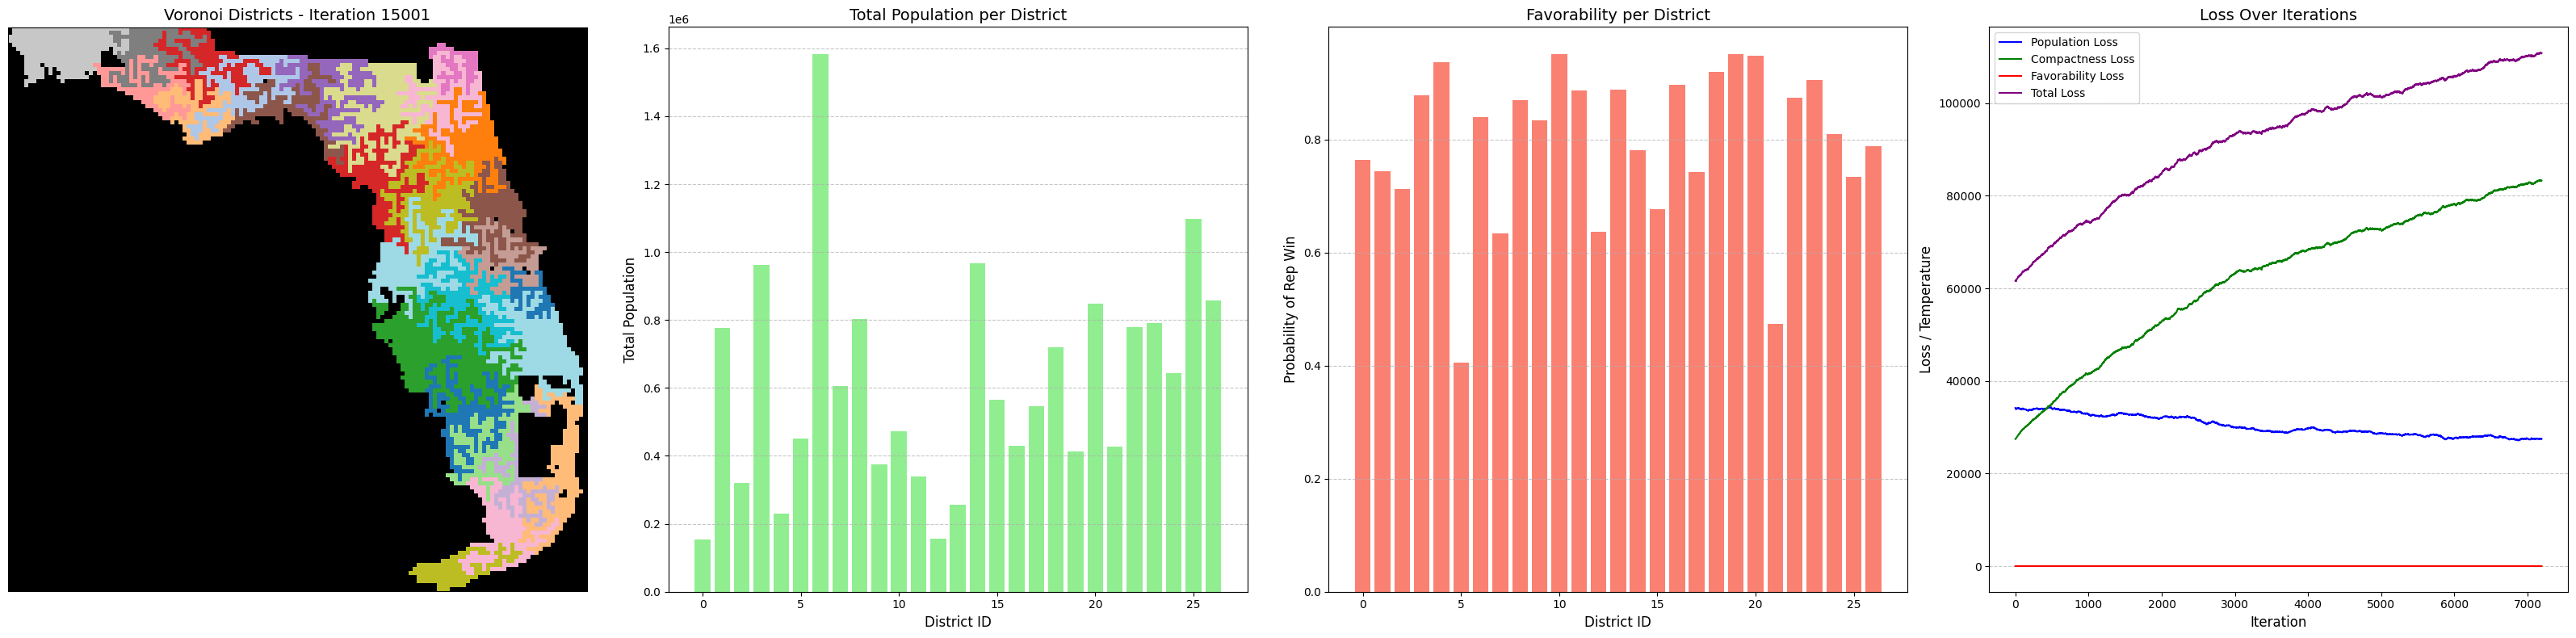

In [ ]:
optimized_district_map = flip_district_map_with_loss_optimized(
        district_map,
        population_masked,
        red_band,          # Pass the red_band for votes
        num_iterations=100000,
        target_pop=target_pop,
        initial_temp=1000,
        cooling_rate=0.995,
        num_districts=27,
        alpha=200,
        beta=0.00000001,
        gamma=1.0,         # Adjust gamma as needed
        w0=-5,             # Adjust based on your logistic model
        w1=0.1,            # Adjust based on your logistic model
        visualize_every=1000
    )